Region Division
===
Algorithm divides map into cohesive groups of nodes - regions.

In [33]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from collections import deque
from sortedcontainers import SortedDict

In [34]:
class InvalidOperationException(Exception):
    pass

def preprocess_map(map_data):
    if len(map_data.shape) == 2:
        return map_data
    elif len(map_data.shape) == 3:
        return np.mean(map_data[:, :, :3], axis = 2) / 255
    else:
        raise InvalidOperationException("Array must be of shape 2 or 3!")
        
def show_gray_image(image):    
    fig, ax = plt.subplots(figsize = (15, 15))
    imgplot = ax.imshow(image, cmap = 'gray', interpolation = 'nearest')

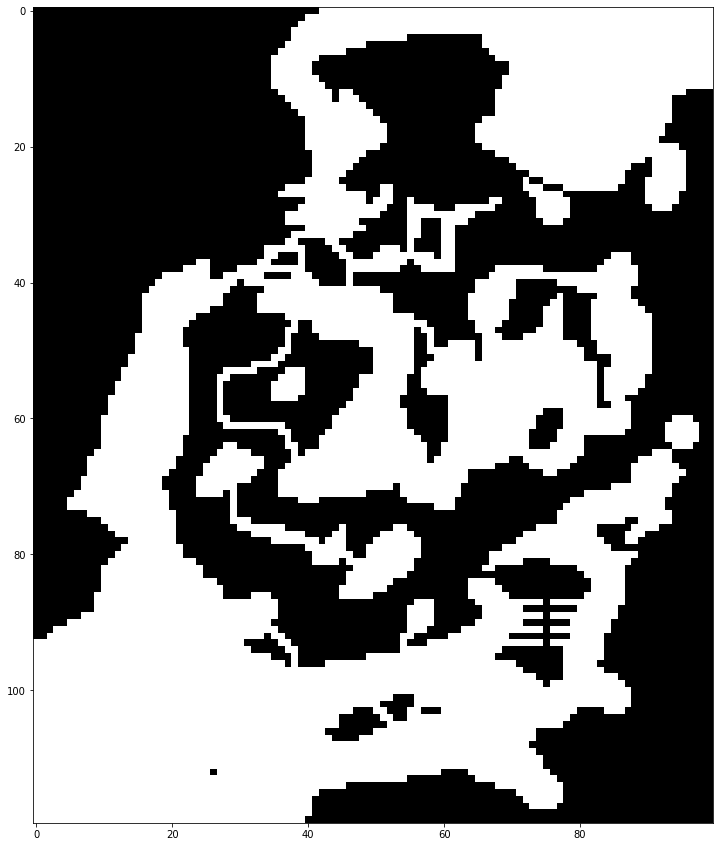

In [35]:
map_data = mpimg.imread('sample.bmp')
map_data = preprocess_map(map_data)
show_gray_image(map_data)

In [36]:
class Vertex:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.adjacent = None   # Nodes, achievable from this one by going in a straight line, but within radius.
        self.nearby = None     # Nodes, achievable from this one, but at distance within radius.
        self.is_edge = None    # True if impassable node is within radius, False otherwise.
        self.edge_dist = None  # Distance to nearest impassable node.
        self.debug = None
        
    # Find all "adjacent" nodes.
    def find_adj(self, vertices, radius):
        self.adjacent = []
        self.is_edge = False
        int_radius = int(np.ceil(radius))
        x_segment = range(max(self.x - int_radius, 0), min(self.x + int_radius + 1, vertices.shape[0]))
        y_segment = range(max(self.y - int_radius, 0), min(self.y + int_radius + 1, vertices.shape[1]))
        for x in x_segment:
            for y in y_segment:
                dist = self.calc_dist(Vertex(x, y))
                if dist > radius:
                    continue
                other = vertices[x, y]
                if other is None:
                    self.is_edge = True
                    self.edge_dist = dist if self.edge_dist is None else min(self.edge_dist, dist)
                    continue
                if self.check_passability(other, vertices):
                    self.adjacent.append(other)
                
    # Find all "nearby" nodes.
    def find_nearby(self, vertices, radius): 

        def update_dist(vertex, dist):
            
            # Remove old info.
            if vertex in dists:
                old_dist = dists[vertex]
                if dist >= old_dist:
                    return
                if old_dist in to_process:
                    old_set = to_process[old_dist]
                    old_set.discard(vertex)
                    
            # Insert new info.
            dists[vertex] = dist
            if dist < radius:
                if dist in to_process:
                    new_set = to_process[dist]
                else:
                    new_set = set()
                    to_process[dist] = new_set
                new_set.add(vertex)
        
        # Dijkstra.
        dists = { self: 0 }                          # (vertex, known dist)
        to_process = SortedDict({ 0: set([self]) })  # (known dist, vertices)
        while len(to_process) > 0:
            dist, cur_set = to_process.popitem(0)
            while len(cur_set) > 0:
                cur = cur_set.pop()
                for other in cur.adjacent:
                    other_dist = dist + cur.calc_dist(other)
                    update_dist(other, other_dist)
                    
        # Fill results.
        self.nearby = {}
        for cur, dist in dists.items():
            if dist > radius:
                continue
            self.nearby[cur] = dist
    
    # Find distance between this node and another one.
    def calc_dist(self, other):
        return np.sqrt((other.x - self.x) ** 2 + (other.y - self.y) ** 2)
    
    # Check if another node is "adjacent" to this one.
    # Another node is "adjacent" to this, iff every point of straight line segment,
    # which connects centers of nodes, belongs to at least one passable node.   
    def check_passability(self, other, vertices):
        dx = other.x - self.x
        dy = other.y - self.y
        x = self.x
        y = self.y
        current = self 
        while current is not other:
            next_x = current.x + math.copysign(0.55, dx)
            next_y = current.y + math.copysign(0.55, dy)
            time_x = np.inf if dx == 0 else max((next_x - x) / dx, 0)
            time_y = np.inf if dy == 0 else max((next_y - y) / dy, 0)
            time = min(time_x, time_y)
            x += time * dx
            y += time * dy
            current = vertices[round(x), round(y)]
            if current is None:
                return False
        return True
        
    def __repr__(self):
        return 'Vertex({0}, {1})'.format(self.x, self.y)

In [37]:
def build_vertices(map_data, radius):
    vertices = np.array([[Vertex(x, y) if map_data[x, y] != 0 else None 
                          for y in range(map_data.shape[1])]
                         for x in range(map_data.shape[0])])
    for row in vertices:
        for vertex in row:
            if vertex is None:
                continue
            vertex.find_adj(vertices, radius)
    for row in vertices:
        for vertex in row:
            if vertex is None:
                continue
            vertex.find_nearby(vertices, radius)
    return vertices
    
def show_submap_on_map(submap, map_data):
    max_map_value = np.max(map_data)
    max_edge_score = np.max(submap)
    image = np.tile(map_data.reshape(map_data.shape + (1, )), (1, 1, 3)) / max_map_value
    image[:, :, 1] *= (1 - submap / max_edge_score)
    image[:, :, 2] *= (1 - submap / max_edge_score)
    fig, ax = plt.subplots(figsize = (15, 15))
    imgplot = ax.imshow(image, interpolation = 'nearest')
    
def set_debug(vertices, value):
    for _, vertex in np.ndenumerate(vertices):
        if vertex is None:
            continue
        vertex.debug = value

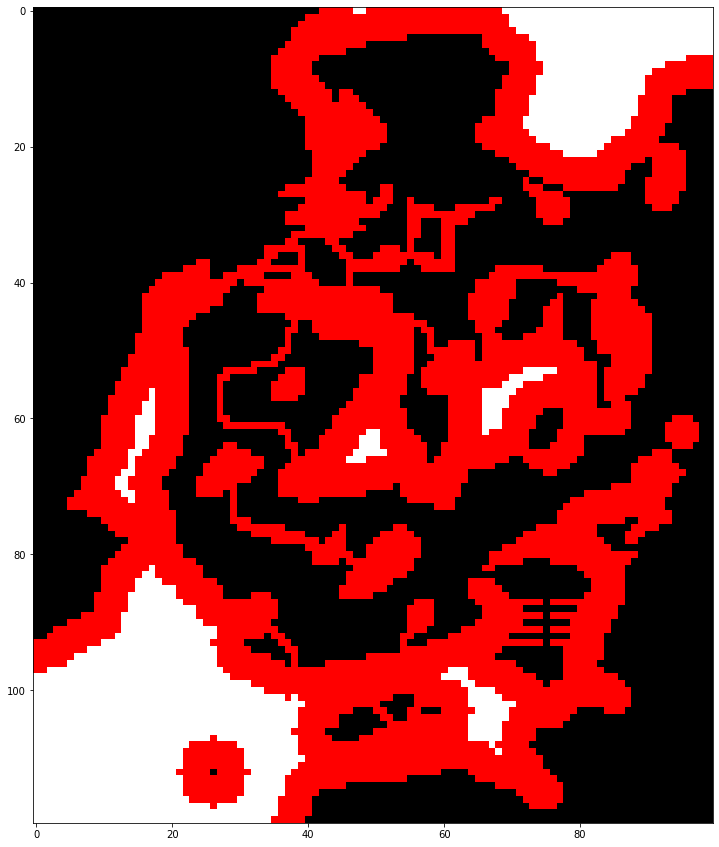

In [61]:
radius = 5
vertices = build_vertices(map_data, radius)

edgemap = np.zeros(map_data.shape)
for (x, y), vertex in np.ndenumerate(vertices):
    if vertex == None:
        continue
    edgemap[x, y] = int(vertex.is_edge)
show_submap_on_map(edgemap, map_data)

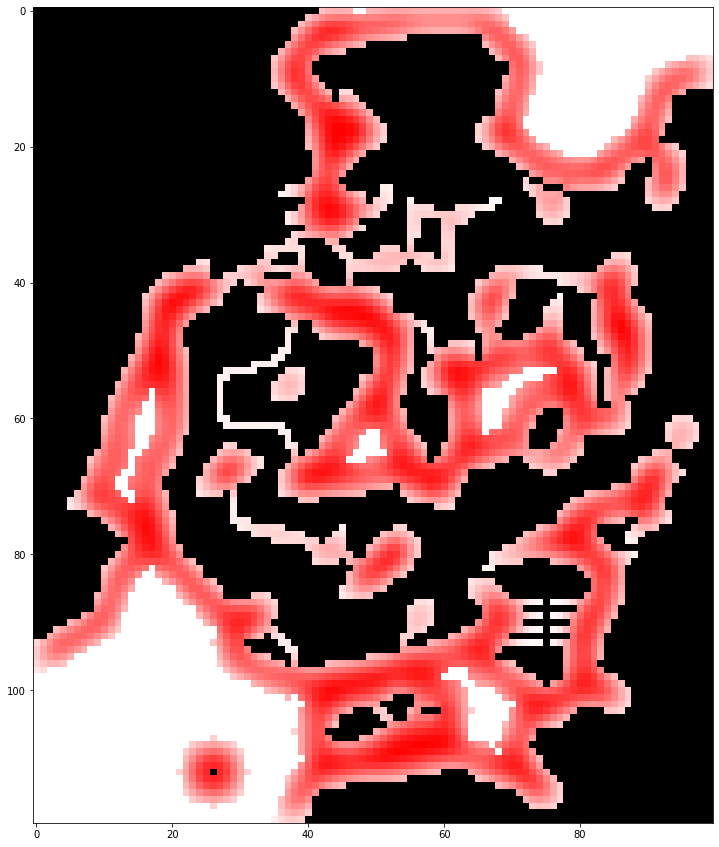

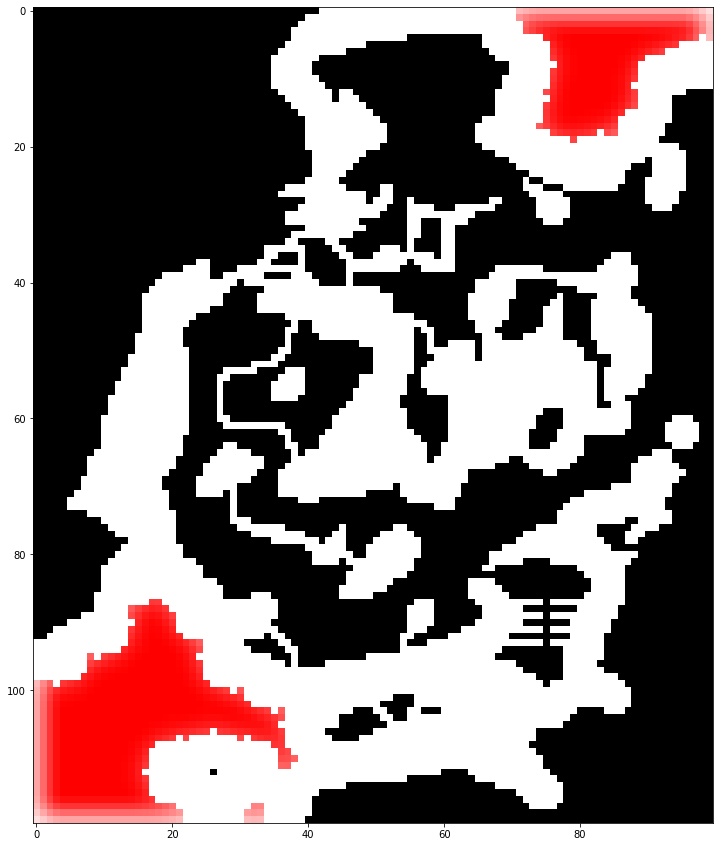

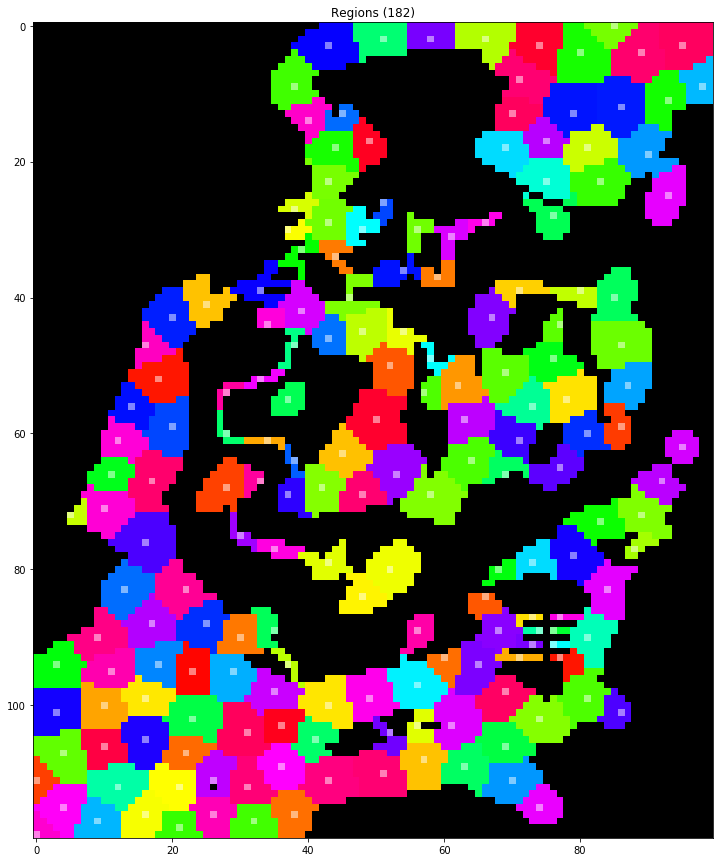

In [67]:
class Scoring:
    
    def __init__(self, vertices, radius):
        self.radius = radius                            # Set region radius.
        self.total = 0                                  # Total number of passable nodes.
        self.total_edge = 0                             # Total number of passable nodes on the edge of passable map.
        self.score_map = np.zeros(vertices.shape)       # Scores determining how nodes are good to be center of region.
        self.owned = 0                                  # Total number of nodes in regions.
        self.owned_edge = 0                             # Total number of edge nodes in regions.
        self.owner_map = np.full(vertices.shape, None)  # Respective region centers.
        for (x, y), vertex in np.ndenumerate(vertices):
            self.total += int(vertex is not None)
            self.total_edge += int(vertex is not None and vertex.is_edge)
        self.only_consider_edges = False                # True if non-edge node should not influence scores. 
        
    # Update score for node.
    def update_score(self, vertex):
        if vertex is None:
            return
        owner = self.owner_map[vertex.x, vertex.y]
        if owner is not None or self.only_consider_edges and not vertex.is_edge:
            score = 0
        else:
            score = 0
            for near in vertex.nearby:  # Better nodes nearby = better this node as region center.        
                near_owner = self.owner_map[near.x, near.y]
                # score += (radius - near.edge_dist + 1) if near.is_edge else 0
                # score += int(near.is_edge)
                subscore = int(near.is_edge or not self.only_consider_edges)
                subscore *= (1 - vertex.nearby[near] / radius)    # Closer nodes = better.
                if near_owner is not None:
                    subscore *= near_owner.nearby[near] / radius  # Further other region centers = better.
                    # subscore *= 0
                score += subscore
        self.score_map[vertex.x, vertex.y] = score
    
    # Update all scores.
    def update_all_scores(self):
        for (x, y), vertex in np.ndenumerate(vertices):
            self.update_score(vertex)

    # Set vertex as center of region and update all nearby-nearby scores.
    def make_owner(self, owner):
        if owner is None:
            return
        updated = set()
        for near in owner.nearby:
            old_owner = self.owner_map[near.x, near.y]
            if old_owner is None or owner.nearby[near] < old_owner.nearby[near]:
                self.owner_map[near.x, near.y] = owner
                if old_owner is None:
                    self.owned += 1
                    self.owned_edge += int(near.is_edge)
        for near in owner.nearby:   
            for near_near in near.nearby:
                if near_near in updated:
                    continue
                self.update_score(near_near)
                updated.add(near_near)

    # Find vertex with maximal score.
    def find_best_score(self):
        candidate = None
        for (x, y), vertex in np.ndenumerate(vertices):
            if vertex is None:
                continue
            if candidate is None or self.score_map[vertex.x, vertex.y] > self.score_map[candidate.x, candidate.y]:
                candidate = vertex
        return candidate

    # Calculate region map.
    def run(self):
        
        # Conider only edges at first...
        self.only_consider_edges = True
        self.update_all_scores()
        show_submap_on_map(self.score_map ** 2, map_data)
        while self.owned_edge < self.total_edge:
            next_best = self.find_best_score()
            self.make_owner(next_best)
            
        # Then distribute else.
        self.only_consider_edges = False
        self.update_all_scores()
        show_submap_on_map(self.score_map ** 2, map_data)
        while self.owned < self.total:
            next_best = self.find_best_score()
            self.make_owner(next_best)
            
        return self.owner_map
            
def show_ownerships_on_map(owner_map, map_data, save_as = None):
    max_map_value = np.max(map_data)
    image = np.tile(map_data.reshape(map_data.shape + (1, )), (1, 1, 3)) / max_map_value
    owners_to_colors = {}
    for (x, y), owner in np.ndenumerate(owner_map):
        if owner is None:
            continue
        owners_to_colors[owner] = [0, 0, 0]
    for owner in owners_to_colors:
        color = np.array([0, 255, random.randrange(0, 256)]) / 255
        random.shuffle(color)
        owners_to_colors[owner] = color
    for (x, y), owner in np.ndenumerate(owner_map):
        if owner is None:
            continue
        color = owners_to_colors[owner]
        if owner.x == x and owner.y == y:
            color = 1 - 0.5 * (1 - color)
        image[x, y] = color
    fig, ax = plt.subplots(figsize = (15, 15))
    plt.title('Regions ({0})'.format(len(owners_to_colors)))
    imgplot = ax.imshow(image, interpolation = 'nearest')
    if save_as is not None:
        mpimg.imsave(save_as, image)
        
            
owner_map = Scoring(vertices, radius).run()
show_ownerships_on_map(owner_map, map_data, save_as = 'output.bmp')